# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [13]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [6]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [5]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [6]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [7]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [8]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [9]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = random_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [10]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 126, 1.0: 126})
Counter({0.0: 63, 1.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [12]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves', xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [15]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.6084 - acc: 0.4365 - val_loss: 0.5375 - val_acc: 0.4444
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5981 - acc: 0.4365 - val_loss: 0.5344 - val_acc: 0.4524
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5889 - acc: 0.4405 - val_loss: 0.5317 - val_acc: 0.4524
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5792 - acc: 0.4484 - val_loss: 0.5295 - val_acc: 0.4524
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5722 - acc: 0.4524 - val_loss: 0.5272 - val_acc: 0.4603
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5656 - acc: 0.4484 - val_loss: 0.5249 - val_acc: 0.4603
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.5581 - acc: 0.4524 - val_loss: 0.5231 - val_acc: 0.4603
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.5528 - acc

252/252 [==============================] - 0s - loss: 0.4973 - acc: 0.5000 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.4973 - acc: 0.5000 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.4973 - acc: 0.5000 - val_loss: 0.4988 - val_acc: 0.5000
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.4973 - acc: 0.5000 - val_loss: 0.4987 - val_acc: 0.5000
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.4973 - acc: 0.5000 - val_loss: 0.4987 - val_acc: 0.5000
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4986 - val_acc: 0.5000
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4986 - val_acc: 0.5000
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.4972 - acc: 0.5000 - val_loss: 0.4986 - val_acc: 0.5000

252/252 [==============================] - 0s - loss: 0.1193 - acc: 0.8730 - val_loss: 0.2407 - val_acc: 0.8333
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.1182 - acc: 0.8730 - val_loss: 0.2395 - val_acc: 0.8254
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1168 - acc: 0.8730 - val_loss: 0.2376 - val_acc: 0.8333
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1154 - acc: 0.8730 - val_loss: 0.2363 - val_acc: 0.8492
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1141 - acc: 0.8730 - val_loss: 0.2354 - val_acc: 0.8492
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1128 - acc: 0.8730 - val_loss: 0.2341 - val_acc: 0.8492
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1118 - acc: 0.8730 - val_loss: 0.2326 - val_acc: 0.8492
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1109 - acc: 0.8730 - val_loss: 0.2296 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.0979 - acc: 0.8770 - val_loss: 0.1529 - val_acc: 0.8254
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8770 - val_loss: 0.1531 - val_acc: 0.8254
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8770 - val_loss: 0.1528 - val_acc: 0.8254
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8770 - val_loss: 0.1532 - val_acc: 0.8254
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0978 - acc: 0.8770 - val_loss: 0.1520 - val_acc: 0.8254
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8770 - val_loss: 0.1522 - val_acc: 0.8254
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8770 - val_loss: 0.1521 - val_acc: 0.8254
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0976 - acc: 0.8770 - val_loss: 0.1513 - val_acc: 0.8333

252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8770 - val_loss: 0.1401 - val_acc: 0.8175
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8810 - val_loss: 0.1400 - val_acc: 0.8175
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8810 - val_loss: 0.1401 - val_acc: 0.8175
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8810 - val_loss: 0.1399 - val_acc: 0.8175
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8770 - val_loss: 0.1401 - val_acc: 0.8175
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8770 - val_loss: 0.1401 - val_acc: 0.8175
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8810 - val_loss: 0.1400 - val_acc: 0.8175
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0959 - acc: 0.8770 - val_loss: 0.1403 - val_acc: 0.8175

252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9008 - val_loss: 0.1175 - val_acc: 0.8571
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9008 - val_loss: 0.1170 - val_acc: 0.8571
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0863 - acc: 0.9008 - val_loss: 0.1169 - val_acc: 0.8571
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0862 - acc: 0.9008 - val_loss: 0.1167 - val_acc: 0.8571
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0861 - acc: 0.9008 - val_loss: 0.1165 - val_acc: 0.8571
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.9008 - val_loss: 0.1163 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.9008 - val_loss: 0.1162 - val_acc: 0.8571
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.9008 - val_loss: 0.1159 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0795 - acc: 0.9008 - val_loss: 0.1067 - val_acc: 0.8810
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1066 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1064 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1064 - val_acc: 0.8810
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0793 - acc: 0.9008 - val_loss: 0.1064 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1063 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0792 - acc: 0.9008 - val_loss: 0.1061 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1045 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1045 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1044 - val_acc: 0.8730
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1045 - val_acc: 0.8730
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1045 - val_acc: 0.8730
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0782 - acc: 0.9048 - val_loss: 0.1045 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8810
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8810
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8810
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8810
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0779 - acc: 0.9048 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.1037 - val_acc:

252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9008 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.1034 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0778 - acc: 0.9048 - val_loss: 0.1035 - val_acc:

252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1030 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9008 - val_loss: 0.1031 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.1030 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1030 - val_acc: 0.8810
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1030 - val_acc:

252/252 [==============================] - 0s - loss: 0.0777 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1030 - val_acc:

252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1028 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1028 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1028 - val_acc: 0.8810
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1029 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9048 - val_loss: 0.1027 - val_acc:

252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1026 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1026 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0776 - acc: 0.9008 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1026 - val_acc: 0.8810
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1027 - val_acc: 0.8810
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1026 - val_acc:

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9008 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9008 - val_loss: 0.1026 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1025 - val_acc:

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1026 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9048 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1024 - val_acc: 0.8810
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0775 - acc: 0.9008 - val_loss: 0.1025 - val_acc: 0.8810
Epoch 1926/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9008 - val_loss: 0.1025 - val_acc:

In [16]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1952/1962 [============================>.] - ETA: 0s[0.060472045568455007, 0.91997961264016315]


<IPython.core.display.Javascript object>


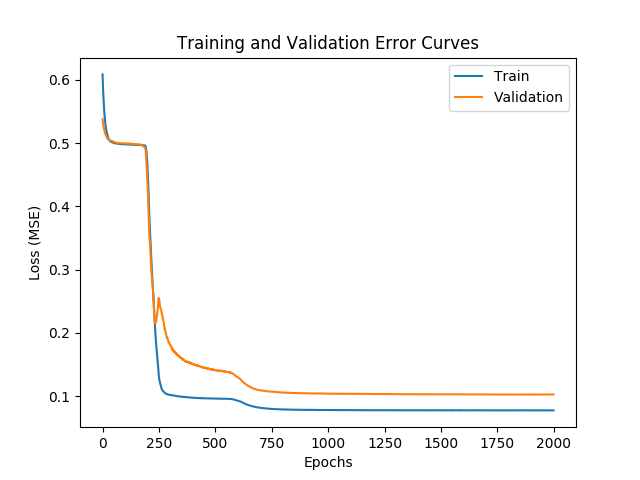

<IPython.core.display.Javascript object>


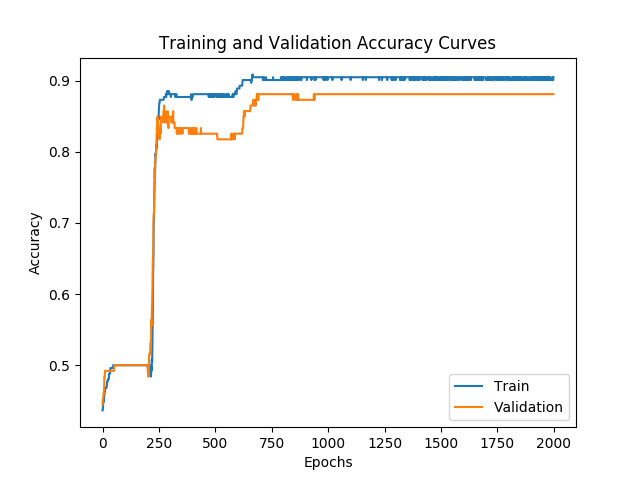

In [17]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 2 (5)

In [18]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4055 - acc: 0.5040 - val_loss: 0.4003 - val_acc: 0.5238
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.3823 - acc: 0.5119 - val_loss: 0.3782 - val_acc: 0.5238
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.3588 - acc: 0.5198 - val_loss: 0.3553 - val_acc: 0.5317
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.3325 - acc: 0.5238 - val_loss: 0.3306 - val_acc: 0.5317
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.3070 - acc: 0.5476 - val_loss: 0.3052 - val_acc: 0.5476
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.2816 - acc: 0.5635 - val_loss: 0.2836 - val_acc: 0.5635
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.2581 - acc: 0.5833 - val_loss: 0.2648 - val_acc: 0.5873
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2362 - acc

252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9087 - val_loss: 0.1077 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.1076 - val_acc: 0.8651
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0762 - acc: 0.9087 - val_loss: 0.1075 - val_acc: 0.8651
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.1074 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9087 - val_loss: 0.1073 - val_acc: 0.8651
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.1073 - val_acc: 0.8571
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9087 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9087 - val_loss: 0.1068 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1050 - val_acc: 0.8810
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1052 - val_acc: 0.8730
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1051 - val_acc: 0.8730
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1053 - val_acc: 0.8730
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1050 - val_acc: 0.8730
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9206 - val_loss: 0.1053 - val_acc: 0.8730
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9206 - val_loss: 0.1052 - val_acc: 0.8730
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9206 - val_loss: 0.1052 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8651
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1105 - val_acc: 0.8651
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1104 - val_acc: 0.8651
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8651
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9206 - val_loss: 0.1107 - val_acc: 0.8651
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8651
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9206 - val_loss: 0.1107 - val_acc: 0.8651
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9206 - val_loss: 0.1108 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9246 - val_loss: 0.1136 - val_acc: 0.8651
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8651
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9246 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1140 - val_acc: 0.8651
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1136 - val_acc: 0.8651
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9246 - val_loss: 0.1133 - val_acc: 0.8651
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9246 - val_loss: 0.1136 - val_acc: 0.8651
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9246 - val_loss: 0.1140 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1137 - val_acc: 0.8571
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1139 - val_acc: 0.8571
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1146 - val_acc: 0.8571
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1143 - val_acc: 0.8571
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1141 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9246 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9246 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9246 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9246 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9246 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9286 - val_loss: 0.1092 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0673 - acc: 0.9286 - val_loss: 0.1091 - val_acc: 0.8730
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9286 - val_loss: 0.1092 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1113 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0662 - acc: 0.9286 - val_loss: 0.1115 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1116 - val_acc: 0.8730
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9286 - val_loss: 0.1114 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0654 - acc: 0.9286 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1130 - val_acc: 0.8730
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8730
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8730
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0653 - acc: 0.9325 - val_loss: 0.1138 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9325 - val_loss: 0.1137 - val_acc: 0.8492
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9325 - val_loss: 0.1137 - val_acc: 0.8571
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1140 - val_acc: 0.8571
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1138 - val_acc: 0.8492
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8571
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1137 - val_acc: 0.8571
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.1138 - val_acc: 0.8571
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9325 - val_loss: 0.1134 - val_acc:

252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1134 - val_acc: 0.8571
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1135 - val_acc: 0.8571
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1135 - val_acc: 0.8571
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1137 - val_acc:

252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1141 - val_acc: 0.8571
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1140 - val_acc: 0.8571
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1142 - val_acc: 0.8571
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1141 - val_acc: 0.8492
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9286 - val_loss: 0.1138 - val_acc: 0.8492
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1134 - val_acc: 0.8492
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8492
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9286 - val_loss: 0.1139 - val_acc:

252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9325 - val_loss: 0.1128 - val_acc: 0.8571
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1129 - val_acc: 0.8492
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1129 - val_acc: 0.8492
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9325 - val_loss: 0.1130 - val_acc: 0.8571
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1132 - val_acc: 0.8492
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1131 - val_acc: 0.8492
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9325 - val_loss: 0.1128 - val_acc:

252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1067 - val_acc: 0.8730
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1066 - val_acc: 0.8730
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1069 - val_acc: 0.8730
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9365 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9325 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9325 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9365 - val_loss: 0.1071 - val_acc: 0.8730
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9365 - val_loss: 0.1071 - val_acc:

252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9365 - val_loss: 0.1075 - val_acc: 0.8651
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9365 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9365 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9405 - val_loss: 0.1068 - val_acc: 0.8651
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9405 - val_loss: 0.1069 - val_acc: 0.8651
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9405 - val_loss: 0.1071 - val_acc:

252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1852/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1075 - val_acc: 0.8571
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9405 - val_loss: 0.1078 - val_acc: 0.8571
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1068 - val_acc: 0.8651
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1070 - val_acc: 0.8651
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8651
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9405 - val_loss: 0.1076 - val_acc:

252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9405 - val_loss: 0.1071 - val_acc: 0.8571
Epoch 1979/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9444 - val_loss: 0.1069 - val_acc: 0.8651
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1078 - val_acc: 0.8571
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1074 - val_acc: 0.8571
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9405 - val_loss: 0.1074 - val_acc: 0.8571
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9444 - val_loss: 0.1072 - val_acc: 0.8571
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9405 - val_loss: 0.1077 - val_acc: 0.8571
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9405 - val_loss: 0.1075 - val_acc:

In [19]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1440/1962 [=====================>........] - ETA: 0s[0.062372322833197803, 0.90417940876656477]


<IPython.core.display.Javascript object>


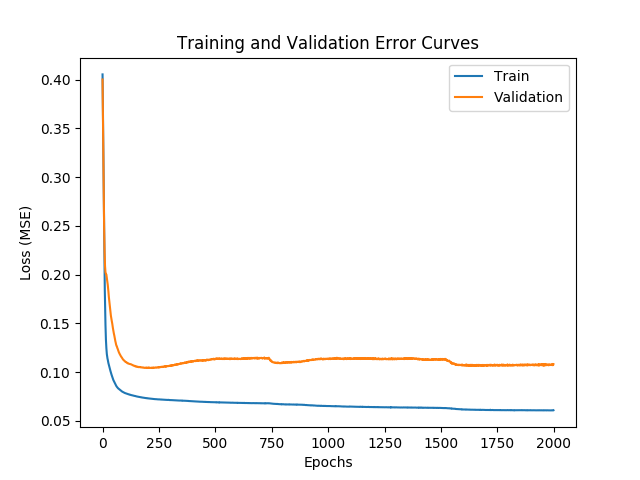

<IPython.core.display.Javascript object>


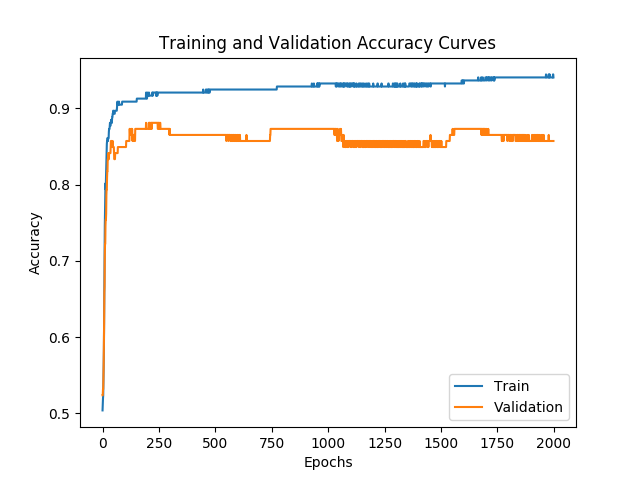

In [20]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 3 (3, 5)

In [22]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5611 - acc: 0.4048 - val_loss: 0.5253 - val_acc: 0.4762
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5479 - acc: 0.4206 - val_loss: 0.5156 - val_acc: 0.4683
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5366 - acc: 0.4206 - val_loss: 0.5067 - val_acc: 0.4683
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5258 - acc: 0.4325 - val_loss: 0.4982 - val_acc: 0.4683
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5163 - acc: 0.4524 - val_loss: 0.4900 - val_acc: 0.4603
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5064 - acc: 0.4563 - val_loss: 0.4800 - val_acc: 0.4762
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4909 - acc: 0.4603 - val_loss: 0.4643 - val_acc: 0.4921
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4690 - acc

252/252 [==============================] - 0s - loss: 0.0736 - acc: 0.9048 - val_loss: 0.0995 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9048 - val_loss: 0.0994 - val_acc: 0.8810
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0732 - acc: 0.9048 - val_loss: 0.0995 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0727 - acc: 0.9087 - val_loss: 0.0992 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9087 - val_loss: 0.0990 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0722 - acc: 0.9087 - val_loss: 0.0989 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.0989 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0718 - acc: 0.9087 - val_loss: 0.0987 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9087 - val_loss: 0.0932 - val_acc: 0.9048
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0643 - acc: 0.9127 - val_loss: 0.0936 - val_acc: 0.9048
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9127 - val_loss: 0.0933 - val_acc: 0.9048
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9087 - val_loss: 0.0934 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9087 - val_loss: 0.0935 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9167 - val_loss: 0.0941 - val_acc: 0.8889
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9167 - val_loss: 0.0939 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9167 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9127 - val_loss: 0.0936 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9127 - val_loss: 0.0940 - val_acc: 0.8889
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9206 - val_loss: 0.0937 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9167 - val_loss: 0.0947 - val_acc: 0.8810
Epoch 513/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0952 - val_acc: 0.8730
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9206 - val_loss: 0.0955 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0953 - val_acc: 0.8730
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0949 - val_acc: 0.8730
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9206 - val_loss: 0.0946 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9127 - val_loss: 0.0944 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9167 - val_loss: 0.0953 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0963 - val_acc: 0.8730
Epoch 641/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9206 - val_loss: 0.0966 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9206 - val_loss: 0.0964 - val_acc: 0.8730
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9206 - val_loss: 0.0960 - val_acc: 0.8730
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9206 - val_loss: 0.0961 - val_acc: 0.8730
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9206 - val_loss: 0.0964 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 769/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0977 - val_acc: 0.8730
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.8730
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0973 - val_acc: 0.8730
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9206 - val_loss: 0.0980 - val_acc: 0.8730
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0573 - acc: 0.9206 - val_loss: 0.0978 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730
Epoch 897/2000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9206 - val_loss: 0.0994 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0998 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0568 - acc: 0.9206 - val_loss: 0.0995 - val_acc: 0.8730
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.8730
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0569 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1009 - val_acc: 0.8730
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9206 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1010 - val_acc: 0.8730
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1012 - val_acc: 0.8730
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0561 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8730
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1004 - val_acc: 0.8730
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0563 - acc: 0.9206 - val_loss: 0.1003 - val_acc: 0.8730
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0562 - acc: 0.9206 - val_loss: 0.1006 - val_acc:

252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9246 - val_loss: 0.1044 - val_acc: 0.8810
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9246 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1036 - val_acc: 0.8810
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1037 - val_acc: 0.8810
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0554 - acc: 0.9246 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.1043 - val_acc: 0.8810
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0557 - acc: 0.9246 - val_loss: 0.1044 - val_acc:

252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1056 - val_acc: 0.8810
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1063 - val_acc: 0.8810
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1060 - val_acc: 0.8810
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9206 - val_loss: 0.1060 - val_acc: 0.8810
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9206 - val_loss: 0.1065 - val_acc: 0.8810
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9246 - val_loss: 0.1069 - val_acc: 0.8730
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.1068 - val_acc: 0.8810
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9206 - val_loss: 0.1068 - val_acc:

252/252 [==============================] - 0s - loss: 0.0548 - acc: 0.9246 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9206 - val_loss: 0.1076 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9206 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0546 - acc: 0.9206 - val_loss: 0.1078 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9206 - val_loss: 0.1080 - val_acc: 0.8810
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0547 - acc: 0.9246 - val_loss: 0.1074 - val_acc: 0.8810
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.1075 - val_acc:

252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9206 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9246 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9206 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9167 - val_loss: 0.1091 - val_acc: 0.8810
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1092 - val_acc: 0.8810
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9167 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9167 - val_loss: 0.1090 - val_acc:

252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1106 - val_acc: 0.8810
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1111 - val_acc: 0.8810
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.1104 - val_acc: 0.8810
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0542 - acc: 0.9206 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9167 - val_loss: 0.1113 - val_acc: 0.8810
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9206 - val_loss: 0.1111 - val_acc: 0.8810
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9167 - val_loss: 0.1110 - val_acc:

252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9246 - val_loss: 0.1119 - val_acc: 0.8810
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9246 - val_loss: 0.1117 - val_acc: 0.8810
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0538 - acc: 0.9206 - val_loss: 0.1120 - val_acc: 0.8810
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1121 - val_acc: 0.8810
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0537 - acc: 0.9246 - val_loss: 0.1122 - val_acc: 0.8810
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.1124 - val_acc:

252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9286 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1139 - val_acc: 0.8810
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9286 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9246 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9286 - val_loss: 0.1146 - val_acc: 0.8810
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0534 - acc: 0.9286 - val_loss: 0.1143 - val_acc:

In [23]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1856/1962 [===========================>..] - ETA: 0s[0.095942563334599551, 0.87359836901121302]


<IPython.core.display.Javascript object>


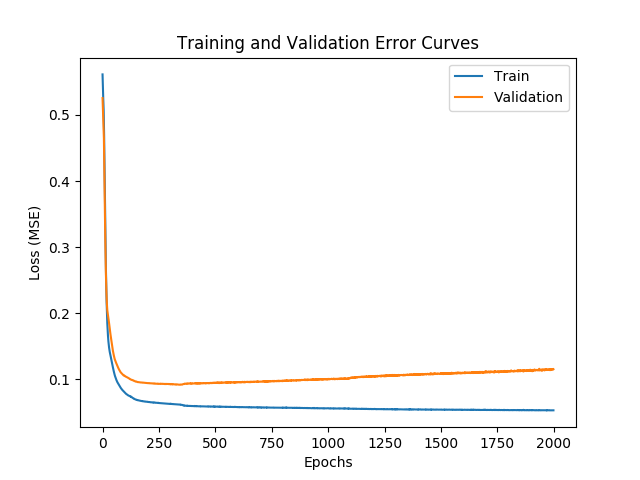

<IPython.core.display.Javascript object>


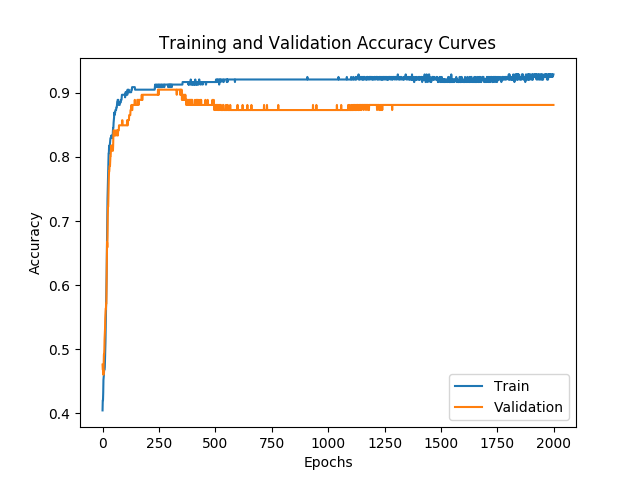

In [24]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 4 (5,3)

In [25]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5604 - acc: 0.4127 - val_loss: 0.5098 - val_acc: 0.4206
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5499 - acc: 0.4246 - val_loss: 0.5002 - val_acc: 0.4444
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.5403 - acc: 0.4286 - val_loss: 0.4924 - val_acc: 0.4444
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.5318 - acc: 0.4405 - val_loss: 0.4857 - val_acc: 0.4444
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5247 - acc: 0.4444 - val_loss: 0.4795 - val_acc: 0.4524
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5170 - acc: 0.4563 - val_loss: 0.4741 - val_acc: 0.4762
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.5104 - acc: 0.4563 - val_loss: 0.4684 - val_acc: 0.4762
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.5031 - acc

252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.8929 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0813 - acc: 0.8929 - val_loss: 0.1135 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0812 - acc: 0.8929 - val_loss: 0.1134 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0810 - acc: 0.8929 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0809 - acc: 0.8929 - val_loss: 0.1133 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0807 - acc: 0.8929 - val_loss: 0.1134 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0806 - acc: 0.8929 - val_loss: 0.1133 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.8929 - val_loss: 0.1129 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1081 - val_acc: 0.8968
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9048 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1079 - val_acc: 0.8968
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9048 - val_loss: 0.1084 - val_acc: 0.8968
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1078 - val_acc: 0.8968
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0731 - acc: 0.9048 - val_loss: 0.1075 - val_acc: 0.8968
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9048 - val_loss: 0.1083 - val_acc: 0.8968
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9048 - val_loss: 0.1087 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0704 - acc: 0.9048 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1064 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1065 - val_acc: 0.8968
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1074 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1073 - val_acc: 0.8968
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.1070 - val_acc: 0.8968
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.1064 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9127 - val_loss: 0.1065 - val_acc: 0.8968
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1057 - val_acc: 0.8889
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9087 - val_loss: 0.1062 - val_acc: 0.8968
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1053 - val_acc: 0.8968
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1052 - val_acc: 0.8889
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1061 - val_acc: 0.8889
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9087 - val_loss: 0.1064 - val_acc: 0.8968
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0674 - acc: 0.9127 - val_loss: 0.1059 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1065 - val_acc: 0.8889
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1064 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1069 - val_acc: 0.8889
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1062 - val_acc: 0.8889
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0655 - acc: 0.9167 - val_loss: 0.1061 - val_acc: 0.8889
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0657 - acc: 0.9167 - val_loss: 0.1056 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1066 - val_acc: 0.8889
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0656 - acc: 0.9167 - val_loss: 0.1065 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9206 - val_loss: 0.1083 - val_acc: 0.8810
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9206 - val_loss: 0.1086 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9167 - val_loss: 0.1081 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9206 - val_loss: 0.1083 - val_acc: 0.8810
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9206 - val_loss: 0.1085 - val_acc: 0.8810
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9206 - val_loss: 0.1085 - val_acc: 0.8889
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9246 - val_loss: 0.1082 - val_acc: 0.8889
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9246 - val_loss: 0.1087 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0638 - acc: 0.9286 - val_loss: 0.1122 - val_acc: 0.8730
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0640 - acc: 0.9286 - val_loss: 0.1120 - val_acc: 0.8730
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0641 - acc: 0.9286 - val_loss: 0.1113 - val_acc: 0.8730
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0639 - acc: 0.9286 - val_loss: 0.1117 - val_acc: 0.8730
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1132 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0637 - acc: 0.9286 - val_loss: 0.1128 - val_acc: 0.8651
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0642 - acc: 0.9286 - val_loss: 0.1134 - val_acc: 0.8730
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.1122 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9325 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.1166 - val_acc: 0.8651
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0626 - acc: 0.9325 - val_loss: 0.1170 - val_acc: 0.8730
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9325 - val_loss: 0.1180 - val_acc: 0.8651
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0627 - acc: 0.9325 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9325 - val_loss: 0.1184 - val_acc: 0.8730
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9325 - val_loss: 0.1168 - val_acc:

252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1209 - val_acc: 0.8730
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1206 - val_acc: 0.8730
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.1203 - val_acc: 0.8730
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1201 - val_acc: 0.8730
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.1207 - val_acc: 0.8730
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1207 - val_acc: 0.8651
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.1200 - val_acc: 0.8730
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.1205 - val_acc:

252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.1212 - val_acc: 0.8730
Epoch 1279/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1209 - val_acc: 0.8730
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.1212 - val_acc: 0.8730
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.1223 - val_acc: 0.8730
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1201 - val_acc: 0.8730
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1208 - val_acc: 0.8730
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.1216 - val_acc: 0.8730
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.1202 - val_acc:

252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.1188 - val_acc: 0.8730
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9325 - val_loss: 0.1198 - val_acc: 0.8730
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9325 - val_loss: 0.1191 - val_acc: 0.8730
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.1195 - val_acc: 0.8730
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.1188 - val_acc: 0.8730
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.1191 - val_acc: 0.8730
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9365 - val_loss: 0.1187 - val_acc: 0.8651
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9365 - val_loss: 0.1193 - val_acc:

252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.0595 - acc: 0.9325 - val_loss: 0.1178 - val_acc: 0.8730
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9325 - val_loss: 0.1176 - val_acc: 0.8651
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0594 - acc: 0.9365 - val_loss: 0.1188 - val_acc: 0.8730
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9365 - val_loss: 0.1168 - val_acc:

252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1171 - val_acc: 0.8651
Epoch 1661/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1183 - val_acc: 0.8651
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0591 - acc: 0.9365 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.1177 - val_acc: 0.8651
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9365 - val_loss: 0.1163 - val_acc:

252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9365 - val_loss: 0.1178 - val_acc: 0.8651
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1174 - val_acc: 0.8651
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1166 - val_acc: 0.8651
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1180 - val_acc: 0.8651
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9365 - val_loss: 0.1175 - val_acc: 0.8651
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9365 - val_loss: 0.1176 - val_acc:

252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1915/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1160 - val_acc: 0.8651
Epoch 1916/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1167 - val_acc: 0.8651
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9365 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1170 - val_acc: 0.8651
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9365 - val_loss: 0.1172 - val_acc: 0.8651
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9365 - val_loss: 0.1173 - val_acc: 0.8651
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9365 - val_loss: 0.1177 - val_acc:

In [26]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1888/1962 [===========================>..] - ETA: 0s[0.057958604170889549, 0.92711518858307851]


<IPython.core.display.Javascript object>


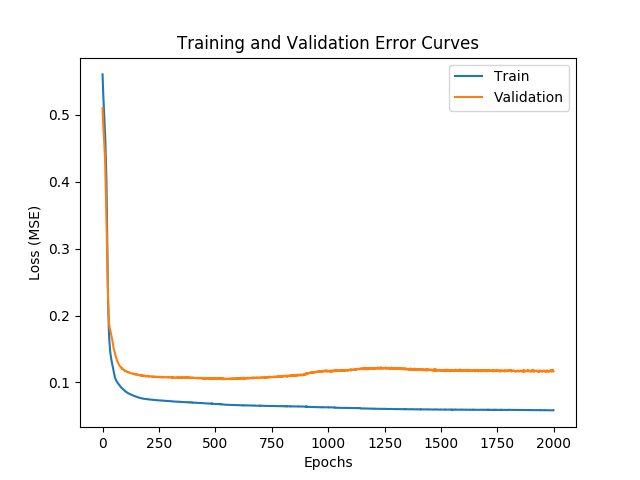

<IPython.core.display.Javascript object>


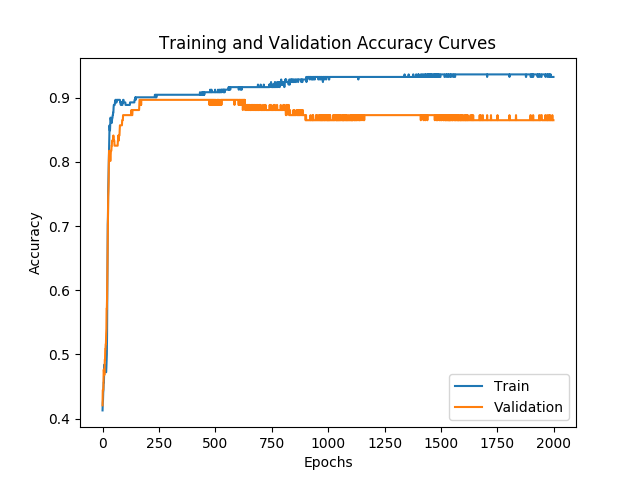

In [27]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 5 (2)

In [28]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 1.1074 - acc: 0.4246 - val_loss: 1.1262 - val_acc: 0.4206
Epoch 2/2000
252/252 [==============================] - 0s - loss: 1.0543 - acc: 0.4246 - val_loss: 1.0780 - val_acc: 0.4286
Epoch 3/2000
252/252 [==============================] - 0s - loss: 1.0118 - acc: 0.4206 - val_loss: 1.0285 - val_acc: 0.4365
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.9623 - acc: 0.4246 - val_loss: 0.9861 - val_acc: 0.4444
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.9267 - acc: 0.4325 - val_loss: 0.9435 - val_acc: 0.4444
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.8843 - acc: 0.4444 - val_loss: 0.9073 - val_acc: 0.4524
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.8517 - acc: 0.4365 - val_loss: 0.8719 - val_acc: 0.4603
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.8181 - acc

252/252 [==============================] - 0s - loss: 0.2049 - acc: 0.7262 - val_loss: 0.2107 - val_acc: 0.7222
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.2031 - acc: 0.7302 - val_loss: 0.2094 - val_acc: 0.7222
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.2016 - acc: 0.7381 - val_loss: 0.2081 - val_acc: 0.7302
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.2002 - acc: 0.7381 - val_loss: 0.2066 - val_acc: 0.7302
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1988 - acc: 0.7381 - val_loss: 0.2053 - val_acc: 0.7302
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1974 - acc: 0.7381 - val_loss: 0.2040 - val_acc: 0.7302
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1961 - acc: 0.7381 - val_loss: 0.2028 - val_acc: 0.7302
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1947 - acc: 0.7381 - val_loss: 0.2015 - val_acc: 0.7381

252/252 [==============================] - 0s - loss: 0.1332 - acc: 0.8175 - val_loss: 0.1445 - val_acc: 0.7937
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.1329 - acc: 0.8175 - val_loss: 0.1442 - val_acc: 0.7857
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.1326 - acc: 0.8175 - val_loss: 0.1440 - val_acc: 0.7857
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.1322 - acc: 0.8175 - val_loss: 0.1437 - val_acc: 0.7857
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.1320 - acc: 0.8175 - val_loss: 0.1435 - val_acc: 0.7857
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.1317 - acc: 0.8175 - val_loss: 0.1432 - val_acc: 0.7937
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.1313 - acc: 0.8175 - val_loss: 0.1429 - val_acc: 0.7937
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.1310 - acc: 0.8175 - val_loss: 0.1428 - val_acc: 0.7937

252/252 [==============================] - 0s - loss: 0.0943 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0942 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0941 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0940 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0939 - acc: 0.8849 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0938 - acc: 0.8849 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0937 - acc: 0.8849 - val_loss: 0.1140 - val_acc: 0.8810
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0936 - acc: 0.8849 - val_loss: 0.1141 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1137 - val_acc: 0.8810
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.9008 - val_loss: 0.1136 - val_acc: 0.8810
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0887 - acc: 0.9008 - val_loss: 0.1135 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1127 - val_acc: 0.8810
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1124 - val_acc: 0.8810
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0865 - acc: 0.9048 - val_loss: 0.1125 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0832 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0833 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8810
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0831 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8810
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0830 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1103 - val_acc: 0.8810
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1102 - val_acc: 0.8810
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1101 - val_acc: 0.8810
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0829 - acc: 0.9048 - val_loss: 0.1100 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1099 - val_acc: 0.8810
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1099 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc:

252/252 [==============================] - 0s - loss: 0.0828 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8810
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8810
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8810
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8810
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8810
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1098 - val_acc: 0.8730
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1093 - val_acc: 0.8730
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc:

252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0827 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8730
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8730
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1094 - val_acc: 0.8730
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8730
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0826 - acc: 0.9048 - val_loss: 0.1096 - val_acc:

In [29]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1440/1962 [=====================>........] - ETA: 0s[0.060406785994714982, 0.92354740061162077]


<IPython.core.display.Javascript object>


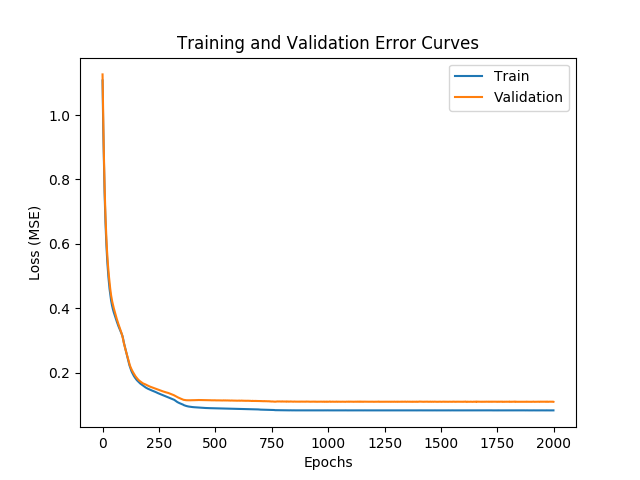

<IPython.core.display.Javascript object>


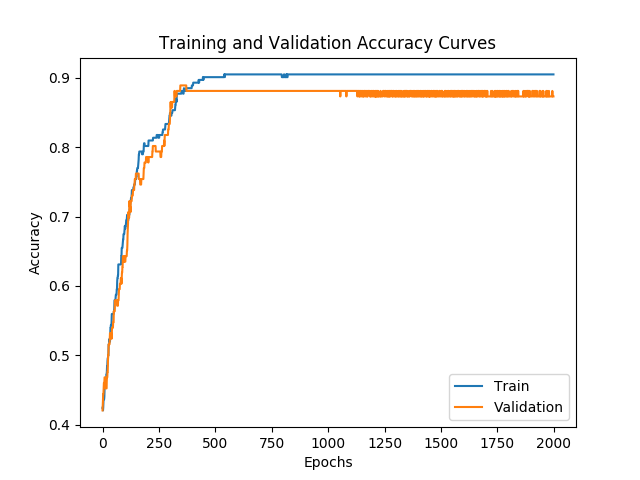

In [30]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## RNA 6 (4)

In [17]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
sgd = optimizers.SGD(lr=0.001)
#sgd = optimizers.SGD(lr=0.01)
classifier.compile(optimizer=sgd, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4883 - acc: 0.5119 - val_loss: 0.4489 - val_acc: 0.5238
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4875 - acc: 0.5119 - val_loss: 0.4487 - val_acc: 0.5238
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4869 - acc: 0.5159 - val_loss: 0.4486 - val_acc: 0.5238
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4862 - acc: 0.5119 - val_loss: 0.4485 - val_acc: 0.5317
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4854 - acc: 0.5119 - val_loss: 0.4485 - val_acc: 0.5317
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4849 - acc: 0.5119 - val_loss: 0.4484 - val_acc: 0.5317
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4842 - acc: 0.5119 - val_loss: 0.4483 - val_acc: 0.5317
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4836 - acc

252/252 [==============================] - 0s - loss: 0.4695 - acc: 0.5198 - val_loss: 0.4505 - val_acc: 0.5159
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.4694 - acc: 0.5198 - val_loss: 0.4505 - val_acc: 0.5159
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.4693 - acc: 0.5198 - val_loss: 0.4506 - val_acc: 0.5159
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.4692 - acc: 0.5198 - val_loss: 0.4506 - val_acc: 0.5159
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.4692 - acc: 0.5198 - val_loss: 0.4507 - val_acc: 0.5159
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.4691 - acc: 0.5198 - val_loss: 0.4507 - val_acc: 0.5159
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.4690 - acc: 0.5198 - val_loss: 0.4508 - val_acc: 0.5159
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.4689 - acc: 0.5198 - val_loss: 0.4508 - val_acc: 0.5159
Epoch 

252/252 [==============================] - 0s - loss: 0.4654 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.4654 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.4653 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.4653 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.4652 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.4652 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.4652 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.4651 - acc: 0.5119 - val_loss: 0.4522 - val_acc: 0.5159

252/252 [==============================] - 0s - loss: 0.4620 - acc: 0.5119 - val_loss: 0.4511 - val_acc: 0.5159
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.4619 - acc: 0.5159 - val_loss: 0.4510 - val_acc: 0.5159
Epoch 195/2000
252/252 [==============================] - ETA: 0s - loss: 0.4403 - acc: 0.562 - 0s - loss: 0.4618 - acc: 0.5159 - val_loss: 0.4510 - val_acc: 0.5159
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.4618 - acc: 0.5159 - val_loss: 0.4510 - val_acc: 0.5159
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.4617 - acc: 0.5159 - val_loss: 0.4509 - val_acc: 0.5159
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.4616 - acc: 0.5159 - val_loss: 0.4509 - val_acc: 0.5159
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.4615 - acc: 0.5159 - val_loss: 0.4509 - val_acc: 0.5159
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.4615 - acc: 0.515

252/252 [==============================] - 0s - loss: 0.4558 - acc: 0.5159 - val_loss: 0.4473 - val_acc: 0.5159
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.4556 - acc: 0.5159 - val_loss: 0.4472 - val_acc: 0.5159
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.4555 - acc: 0.5159 - val_loss: 0.4471 - val_acc: 0.5159
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.4554 - acc: 0.5159 - val_loss: 0.4470 - val_acc: 0.5159
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.4553 - acc: 0.5159 - val_loss: 0.4469 - val_acc: 0.5159
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.4552 - acc: 0.5159 - val_loss: 0.4468 - val_acc: 0.5159
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.4550 - acc: 0.5159 - val_loss: 0.4467 - val_acc: 0.5159
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.4549 - acc: 0.5159 - val_loss: 0.4465 - val_acc: 0.5159

252/252 [==============================] - 0s - loss: 0.4402 - acc: 0.5238 - val_loss: 0.4270 - val_acc: 0.5159
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.4396 - acc: 0.5278 - val_loss: 0.4263 - val_acc: 0.5159
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.4390 - acc: 0.5278 - val_loss: 0.4256 - val_acc: 0.5159
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.4384 - acc: 0.5278 - val_loss: 0.4249 - val_acc: 0.5159
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.4378 - acc: 0.5278 - val_loss: 0.4242 - val_acc: 0.5159
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.4372 - acc: 0.5278 - val_loss: 0.4235 - val_acc: 0.5159
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.4367 - acc: 0.5278 - val_loss: 0.4228 - val_acc: 0.5159
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.4361 - acc: 0.5278 - val_loss: 0.4221 - val_acc: 0.5159

252/252 [==============================] - 0s - loss: 0.3960 - acc: 0.5198 - val_loss: 0.3718 - val_acc: 0.5476
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.3953 - acc: 0.5198 - val_loss: 0.3709 - val_acc: 0.5476
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.3946 - acc: 0.5198 - val_loss: 0.3700 - val_acc: 0.5476
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.3939 - acc: 0.5159 - val_loss: 0.3691 - val_acc: 0.5476
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.3933 - acc: 0.5159 - val_loss: 0.3681 - val_acc: 0.5476
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.3925 - acc: 0.5159 - val_loss: 0.3670 - val_acc: 0.5476
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.3917 - acc: 0.5159 - val_loss: 0.3660 - val_acc: 0.5476
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.3910 - acc: 0.5159 - val_loss: 0.3650 - val_acc: 0.5476

252/252 [==============================] - 0s - loss: 0.3296 - acc: 0.5198 - val_loss: 0.3049 - val_acc: 0.5476
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.3283 - acc: 0.5198 - val_loss: 0.3037 - val_acc: 0.5476
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.3270 - acc: 0.5159 - val_loss: 0.3025 - val_acc: 0.5476
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.3257 - acc: 0.5198 - val_loss: 0.3012 - val_acc: 0.5476
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.3244 - acc: 0.5198 - val_loss: 0.3000 - val_acc: 0.5476
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.3231 - acc: 0.5198 - val_loss: 0.2986 - val_acc: 0.5476
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.3216 - acc: 0.5198 - val_loss: 0.2973 - val_acc: 0.5476
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.3203 - acc: 0.5198 - val_loss: 0.2960 - val_acc: 0.5476

252/252 [==============================] - 0s - loss: 0.2412 - acc: 0.6468 - val_loss: 0.2137 - val_acc: 0.6746
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.2402 - acc: 0.6468 - val_loss: 0.2128 - val_acc: 0.6746
Epoch 515/2000
252/252 [==============================] - ETA: 0s - loss: 0.1923 - acc: 0.812 - 0s - loss: 0.2392 - acc: 0.6508 - val_loss: 0.2119 - val_acc: 0.6905
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.2382 - acc: 0.6587 - val_loss: 0.2110 - val_acc: 0.6984
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.2372 - acc: 0.6667 - val_loss: 0.2101 - val_acc: 0.6984
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.2362 - acc: 0.6706 - val_loss: 0.2093 - val_acc: 0.7063
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.2352 - acc: 0.6746 - val_loss: 0.2084 - val_acc: 0.7222
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.2342 - acc: 0.674

252/252 [==============================] - 0s - loss: 0.1906 - acc: 0.7579 - val_loss: 0.1749 - val_acc: 0.8016
Epoch 577/2000
252/252 [==============================] - 0s - loss: 0.1900 - acc: 0.7579 - val_loss: 0.1745 - val_acc: 0.8016
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.1895 - acc: 0.7619 - val_loss: 0.1741 - val_acc: 0.8016
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.1889 - acc: 0.7619 - val_loss: 0.1738 - val_acc: 0.8016
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.1884 - acc: 0.7619 - val_loss: 0.1734 - val_acc: 0.8016
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.1878 - acc: 0.7698 - val_loss: 0.1731 - val_acc: 0.8016
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.1873 - acc: 0.7698 - val_loss: 0.1727 - val_acc: 0.8016
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.1868 - acc: 0.7698 - val_loss: 0.1724 - val_acc: 0.8016

252/252 [==============================] - 0s - loss: 0.1604 - acc: 0.7937 - val_loss: 0.1586 - val_acc: 0.8254
Epoch 641/2000
252/252 [==============================] - 0s - loss: 0.1600 - acc: 0.7937 - val_loss: 0.1585 - val_acc: 0.8254
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.1597 - acc: 0.7937 - val_loss: 0.1583 - val_acc: 0.8254
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.1593 - acc: 0.7976 - val_loss: 0.1582 - val_acc: 0.8333
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.1589 - acc: 0.7976 - val_loss: 0.1580 - val_acc: 0.8333
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.1586 - acc: 0.7976 - val_loss: 0.1578 - val_acc: 0.8333
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.1582 - acc: 0.7976 - val_loss: 0.1577 - val_acc: 0.8333
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.1579 - acc: 0.7976 - val_loss: 0.1575 - val_acc: 0.8333

252/252 [==============================] - 0s - loss: 0.1393 - acc: 0.8413 - val_loss: 0.1528 - val_acc: 0.8492
Epoch 705/2000
252/252 [==============================] - 0s - loss: 0.1390 - acc: 0.8413 - val_loss: 0.1527 - val_acc: 0.8492
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.1388 - acc: 0.8413 - val_loss: 0.1527 - val_acc: 0.8492
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.1385 - acc: 0.8413 - val_loss: 0.1526 - val_acc: 0.8492
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.1383 - acc: 0.8413 - val_loss: 0.1526 - val_acc: 0.8492
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.1380 - acc: 0.8413 - val_loss: 0.1525 - val_acc: 0.8492
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.1378 - acc: 0.8413 - val_loss: 0.1525 - val_acc: 0.8492
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.1376 - acc: 0.8373 - val_loss: 0.1524 - val_acc: 0.8492

252/252 [==============================] - 0s - loss: 0.1274 - acc: 0.8413 - val_loss: 0.1510 - val_acc: 0.8571
Epoch 769/2000
252/252 [==============================] - 0s - loss: 0.1273 - acc: 0.8373 - val_loss: 0.1509 - val_acc: 0.8571
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.1271 - acc: 0.8373 - val_loss: 0.1509 - val_acc: 0.8571
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.1270 - acc: 0.8373 - val_loss: 0.1509 - val_acc: 0.8571
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.1269 - acc: 0.8373 - val_loss: 0.1509 - val_acc: 0.8571
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.1267 - acc: 0.8373 - val_loss: 0.1509 - val_acc: 0.8571
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.1266 - acc: 0.8373 - val_loss: 0.1509 - val_acc: 0.8571
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.1265 - acc: 0.8413 - val_loss: 0.1509 - val_acc: 0.8571

252/252 [==============================] - 0s - loss: 0.1208 - acc: 0.8571 - val_loss: 0.1506 - val_acc: 0.8651
Epoch 833/2000
252/252 [==============================] - 0s - loss: 0.1207 - acc: 0.8571 - val_loss: 0.1506 - val_acc: 0.8651
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.1207 - acc: 0.8571 - val_loss: 0.1505 - val_acc: 0.8651
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.1206 - acc: 0.8571 - val_loss: 0.1506 - val_acc: 0.8651
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.1205 - acc: 0.8571 - val_loss: 0.1506 - val_acc: 0.8651
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.1204 - acc: 0.8571 - val_loss: 0.1506 - val_acc: 0.8651
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.1204 - acc: 0.8571 - val_loss: 0.1506 - val_acc: 0.8651
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.1203 - acc: 0.8571 - val_loss: 0.1506 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.1171 - acc: 0.8611 - val_loss: 0.1498 - val_acc: 0.8651
Epoch 897/2000
252/252 [==============================] - 0s - loss: 0.1171 - acc: 0.8611 - val_loss: 0.1498 - val_acc: 0.8651
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.1170 - acc: 0.8611 - val_loss: 0.1498 - val_acc: 0.8651
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.1170 - acc: 0.8611 - val_loss: 0.1497 - val_acc: 0.8651
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8611 - val_loss: 0.1497 - val_acc: 0.8651
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8611 - val_loss: 0.1497 - val_acc: 0.8651
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.1169 - acc: 0.8611 - val_loss: 0.1497 - val_acc: 0.8651
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.1168 - acc: 0.8611 - val_loss: 0.1496 - val_acc: 0.8651

252/252 [==============================] - 0s - loss: 0.1148 - acc: 0.8611 - val_loss: 0.1483 - val_acc: 0.8413
Epoch 961/2000
252/252 [==============================] - 0s - loss: 0.1148 - acc: 0.8611 - val_loss: 0.1482 - val_acc: 0.8413
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.1148 - acc: 0.8611 - val_loss: 0.1482 - val_acc: 0.8413
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.1147 - acc: 0.8651 - val_loss: 0.1482 - val_acc: 0.8413
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.1147 - acc: 0.8651 - val_loss: 0.1482 - val_acc: 0.8413
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.1147 - acc: 0.8611 - val_loss: 0.1481 - val_acc: 0.8413
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.1146 - acc: 0.8611 - val_loss: 0.1481 - val_acc: 0.8413
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.1146 - acc: 0.8611 - val_loss: 0.1481 - val_acc: 0.8413

252/252 [==============================] - 0s - loss: 0.1131 - acc: 0.8611 - val_loss: 0.1462 - val_acc: 0.8413
Epoch 1025/2000
252/252 [==============================] - 0s - loss: 0.1130 - acc: 0.8611 - val_loss: 0.1462 - val_acc: 0.8413
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.1130 - acc: 0.8611 - val_loss: 0.1462 - val_acc: 0.8413
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.1130 - acc: 0.8611 - val_loss: 0.1461 - val_acc: 0.8413
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.1129 - acc: 0.8611 - val_loss: 0.1461 - val_acc: 0.8413
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.1129 - acc: 0.8611 - val_loss: 0.1460 - val_acc: 0.8413
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.1129 - acc: 0.8611 - val_loss: 0.1460 - val_acc: 0.8413
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.1128 - acc: 0.8611 - val_loss: 0.1459 - val_acc:

252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8651 - val_loss: 0.1441 - val_acc: 0.8413
Epoch 1088/2000
252/252 [==============================] - 0s - loss: 0.1112 - acc: 0.8651 - val_loss: 0.1441 - val_acc: 0.8413
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8651 - val_loss: 0.1441 - val_acc: 0.8413
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8651 - val_loss: 0.1440 - val_acc: 0.8413
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8651 - val_loss: 0.1440 - val_acc: 0.8413
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.1111 - acc: 0.8651 - val_loss: 0.1440 - val_acc: 0.8413
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8651 - val_loss: 0.1440 - val_acc: 0.8413
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.1110 - acc: 0.8651 - val_loss: 0.1439 - val_acc:

252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8651 - val_loss: 0.1422 - val_acc: 0.8571
Epoch 1151/2000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8651 - val_loss: 0.1422 - val_acc: 0.8571
Epoch 1152/2000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8651 - val_loss: 0.1421 - val_acc: 0.8571
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.1096 - acc: 0.8651 - val_loss: 0.1421 - val_acc: 0.8571
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8651 - val_loss: 0.1421 - val_acc: 0.8571
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8651 - val_loss: 0.1420 - val_acc: 0.8571
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8651 - val_loss: 0.1420 - val_acc: 0.8571
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.1095 - acc: 0.8651 - val_loss: 0.1420 - val_acc:

252/252 [==============================] - 0s - loss: 0.1083 - acc: 0.8611 - val_loss: 0.1402 - val_acc: 0.8571
Epoch 1214/2000
252/252 [==============================] - 0s - loss: 0.1083 - acc: 0.8611 - val_loss: 0.1402 - val_acc: 0.8571
Epoch 1215/2000
252/252 [==============================] - 0s - loss: 0.1083 - acc: 0.8611 - val_loss: 0.1401 - val_acc: 0.8571
Epoch 1216/2000
252/252 [==============================] - 0s - loss: 0.1083 - acc: 0.8611 - val_loss: 0.1401 - val_acc: 0.8571
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8611 - val_loss: 0.1401 - val_acc: 0.8571
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8611 - val_loss: 0.1400 - val_acc: 0.8571
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8611 - val_loss: 0.1400 - val_acc: 0.8571
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.1082 - acc: 0.8611 - val_loss: 0.1400 - val_acc:

252/252 [==============================] - 0s - loss: 0.1072 - acc: 0.8611 - val_loss: 0.1383 - val_acc: 0.8571
Epoch 1278/2000
252/252 [==============================] - 0s - loss: 0.1072 - acc: 0.8611 - val_loss: 0.1383 - val_acc: 0.8571
Epoch 1279/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8611 - val_loss: 0.1383 - val_acc: 0.8571
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8611 - val_loss: 0.1382 - val_acc: 0.8571
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8611 - val_loss: 0.1382 - val_acc: 0.8571
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8611 - val_loss: 0.1382 - val_acc: 0.8571
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8611 - val_loss: 0.1382 - val_acc: 0.8571
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.1071 - acc: 0.8611 - val_loss: 0.1381 - val_acc:

252/252 [==============================] - 0s - loss: 0.1054 - acc: 0.8611 - val_loss: 0.1362 - val_acc: 0.8571
Epoch 1342/2000
252/252 [==============================] - 0s - loss: 0.1053 - acc: 0.8611 - val_loss: 0.1362 - val_acc: 0.8571
Epoch 1343/2000
252/252 [==============================] - 0s - loss: 0.1053 - acc: 0.8611 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.1053 - acc: 0.8611 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.1052 - acc: 0.8611 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.1052 - acc: 0.8611 - val_loss: 0.1361 - val_acc: 0.8571
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.1052 - acc: 0.8611 - val_loss: 0.1360 - val_acc: 0.8571
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.1052 - acc: 0.8611 - val_loss: 0.1360 - val_acc:

252/252 [==============================] - 0s - loss: 0.1038 - acc: 0.8651 - val_loss: 0.1349 - val_acc: 0.8571
Epoch 1405/2000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8651 - val_loss: 0.1349 - val_acc: 0.8571
Epoch 1406/2000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8651 - val_loss: 0.1349 - val_acc: 0.8571
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8651 - val_loss: 0.1349 - val_acc: 0.8571
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8651 - val_loss: 0.1349 - val_acc: 0.8571
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.1037 - acc: 0.8651 - val_loss: 0.1349 - val_acc: 0.8571
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.1036 - acc: 0.8651 - val_loss: 0.1348 - val_acc: 0.8571
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.1036 - acc: 0.8651 - val_loss: 0.1348 - val_acc:

252/252 [==============================] - 0s - loss: 0.1025 - acc: 0.8690 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 1469/2000
252/252 [==============================] - 0s - loss: 0.1025 - acc: 0.8690 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 1470/2000
252/252 [==============================] - ETA: 0s - loss: 0.1212 - acc: 0.812 - 0s - loss: 0.1024 - acc: 0.8690 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8690 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8690 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8690 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.1024 - acc: 0.8690 - val_loss: 0.1338 - val_acc: 0.8492
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.1024 - acc

252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8690 - val_loss: 0.1329 - val_acc: 0.8492
Epoch 1532/2000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8690 - val_loss: 0.1329 - val_acc: 0.8492
Epoch 1533/2000
252/252 [==============================] - 0s - loss: 0.1015 - acc: 0.8690 - val_loss: 0.1329 - val_acc: 0.8492
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8690 - val_loss: 0.1328 - val_acc: 0.8492
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8690 - val_loss: 0.1328 - val_acc: 0.8492
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8690 - val_loss: 0.1328 - val_acc: 0.8492
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8690 - val_loss: 0.1328 - val_acc: 0.8492
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.1014 - acc: 0.8690 - val_loss: 0.1328 - val_acc:

252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8690 - val_loss: 0.1320 - val_acc: 0.8492
Epoch 1596/2000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8690 - val_loss: 0.1320 - val_acc: 0.8492
Epoch 1597/2000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8690 - val_loss: 0.1320 - val_acc: 0.8492
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.1007 - acc: 0.8690 - val_loss: 0.1320 - val_acc: 0.8492
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8690 - val_loss: 0.1319 - val_acc: 0.8492
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8690 - val_loss: 0.1319 - val_acc: 0.8492
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8690 - val_loss: 0.1319 - val_acc: 0.8492
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.1006 - acc: 0.8690 - val_loss: 0.1319 - val_acc:

252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8690 - val_loss: 0.1311 - val_acc: 0.8492
Epoch 1659/2000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8690 - val_loss: 0.1311 - val_acc: 0.8492
Epoch 1660/2000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8690 - val_loss: 0.1311 - val_acc: 0.8492
Epoch 1661/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8690 - val_loss: 0.1311 - val_acc: 0.8492
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.1000 - acc: 0.8690 - val_loss: 0.1310 - val_acc: 0.8492
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8690 - val_loss: 0.1310 - val_acc: 0.8492
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8690 - val_loss: 0.1310 - val_acc: 0.8492
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0999 - acc: 0.8690 - val_loss: 0.1310 - val_acc:

252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1301 - val_acc: 0.8571
Epoch 1722/2000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1301 - val_acc: 0.8571
Epoch 1723/2000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1301 - val_acc: 0.8571
Epoch 1724/2000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1301 - val_acc: 0.8571
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1301 - val_acc: 0.8571
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1301 - val_acc: 0.8571
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1300 - val_acc: 0.8571
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0993 - acc: 0.8690 - val_loss: 0.1300 - val_acc:

252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8770 - val_loss: 0.1293 - val_acc: 0.8651
Epoch 1786/2000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8770 - val_loss: 0.1293 - val_acc: 0.8651
Epoch 1787/2000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8770 - val_loss: 0.1293 - val_acc: 0.8651
Epoch 1788/2000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8770 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8770 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8770 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0987 - acc: 0.8770 - val_loss: 0.1292 - val_acc: 0.8651
Epoch 1792/2000
252/252 [==============================] - ETA: 0s - loss: 0.0869 - acc: 0.937 - 0s - loss: 0.0987 - acc

252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1285 - val_acc: 0.8651
Epoch 1849/2000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1850/2000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1851/2000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1852/2000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1284 - val_acc: 0.8651
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0982 - acc: 0.8810 - val_loss: 0.1284 - val_acc:

252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8810 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 1913/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8810 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 1914/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8810 - val_loss: 0.1276 - val_acc: 0.8651
Epoch 1915/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8849 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 1916/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8849 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8849 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8849 - val_loss: 0.1275 - val_acc: 0.8651
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0977 - acc: 0.8849 - val_loss: 0.1275 - val_acc:

252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8849 - val_loss: 0.1267 - val_acc: 0.8651
Epoch 1976/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 1977/2000
252/252 [==============================] - 0s - loss: 0.0973 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 1978/2000
252/252 [==============================] - ETA: 0s - loss: 0.1163 - acc: 0.843 - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 1979/2000
252/252 [==============================] - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0972 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8651
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0972 - acc

In [18]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1920/1962 [============================>.] - ETA: 0s[0.059463163900448278, 0.93323139653414888]


<IPython.core.display.Javascript object>


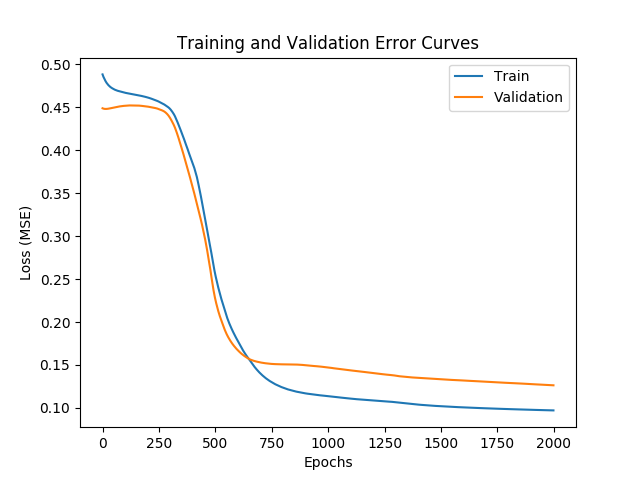

<IPython.core.display.Javascript object>


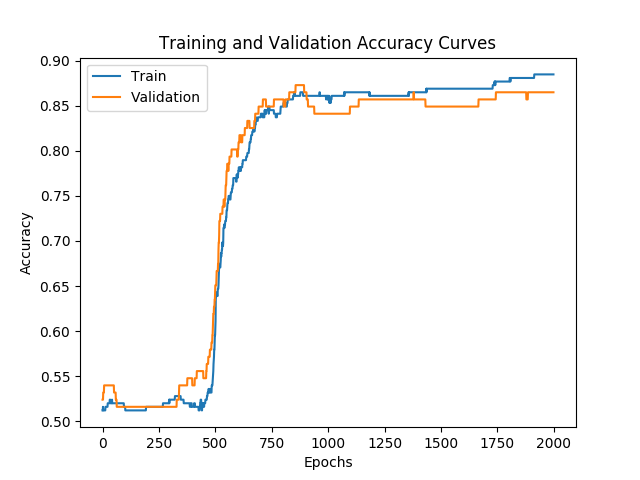

In [19]:
plot_training_error_curves(history)
plot_training_acc_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [121]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1774  124]
 [   9   55]]

Train Loss:       0.0725
Validation Loss:  0.0816
Accuracy:         0.9322
Recall:           0.8594
Precision:        0.3073
F1:               0.4527
AUROC:            0.9239
